Michael Haugan <br>
MSDS 422 - Winter 2019 <br>
Assignment 4: Random Forests and Gradient Boosting <br>

# overview
Use all explanatory variables (except neighborhood) and all 506 census tract observations from the Boston Housing Study. Use one of two response variables: (1) the median value of homes in thousands of 1970 dollars or (2) the log median value of homes in thousands of 1970 dollars. Employ at least two regression modeling methods selected from those discussed in Chapter 4 of the Géron (2017) textbook: linear regression, stochastic gradient descent, ridge regression, lasso regression, and elastic net. Also employ random forests to the regression problem, following methods described in Géron (2017) Chapter 7. Evaluate these methods within a cross-validation design, using root mean-squared error (RMSE) as an index of prediction error. Python scikit-learn should be your primary environment for conducting this research.

Try alternative versions of random forests and gradient boosting. Select a best modeling method for the Boston Housing Study. Employ that method on the full data set, obtaining results that you can report to management.

# objective
Regarding the management problem, imagine that you again are advising a real estate brokerage firm in its attempt to employ machine learning methods. The firm wants to use machine learning to complement conventional methods for assessing the market value of residential real estate. Of the modeling methods examined in your study, which would you recommend to management and why? Reviewing the results of the random forests and gradient boosting model you have selected to present to management, which explanatory variables are most important in predicting home prices?

# setup

In [403]:
# import packages and set parameters
SET_FIT_INTERCEPT = True
RANDOM_SEED = 1
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, make_scorer  
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from math import sqrt  # for root mean-squared error calculation
# suppress warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import warnings
warnings.filterwarnings('ignore')

# eda

In [185]:
# read in data and view head
boston_input = pd.read_csv('boston.csv')
boston_input.head()

,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,Nahant,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,Swampscott,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,Swanpscott,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,Marblehead,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,Marblehead,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [112]:
# view data types, variables, and sample size for each
boston_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
neighborhood    506 non-null object
crim            506 non-null float64
zn              506 non-null float64
indus           506 non-null float64
chas            506 non-null int64
nox             506 non-null float64
rooms           506 non-null float64
age             506 non-null float64
dis             506 non-null float64
rad             506 non-null int64
tax             506 non-null int64
ptratio         506 non-null float64
lstat           506 non-null float64
mv              506 non-null float64
dtypes: float64(10), int64(3), object(1)
memory usage: 55.4+ KB


In [186]:
# drop neighborhood
boston = boston_input.drop('neighborhood', 1)
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int64
nox        506 non-null float64
rooms      506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null int64
tax        506 non-null int64
ptratio    506 non-null float64
lstat      506 non-null float64
mv         506 non-null float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


In [114]:
# view summary stats
boston.describe()

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.528854
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.182176
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


vastly differing scales - will want to standardize

<Figure size 432x288 with 0 Axes>

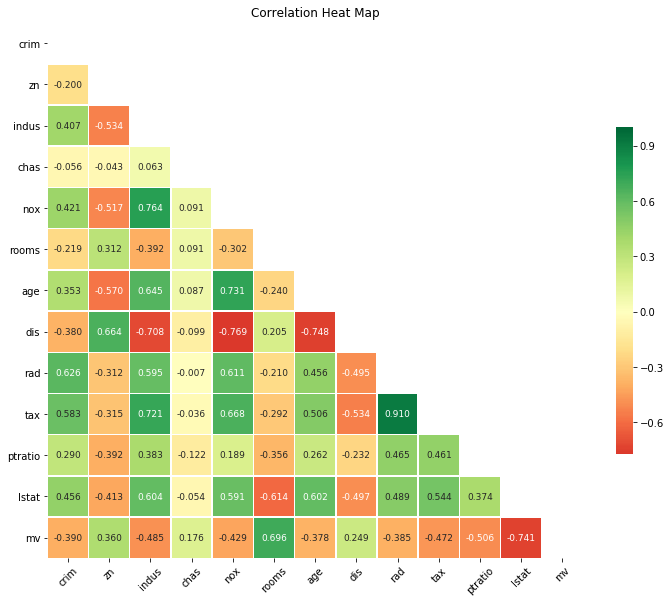

In [115]:
# correlation heat map setup for seaborn
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='RdYlGn', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.pdf', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)      

np.set_printoptions(precision=3)
corr_chart(df_corr = boston) 

I am looking at multiple things here. First, correlation with our response variable mv (median home value) and all 
the predictors. There seems to be a strong correlation with rooms (avg # of rooms per home) and a strong negative
correlation with lstat (% of pop of lower socio-econ status).
positive = rooms
negative = lstat

The other thing I am looking for is if multicollinearity exists within our predictors. This is where we have strong
correlation between our predictors. There does seem to be some potential multicollinearity within this data.
positive = nox/indus, age/indus, age/nox, dis/zn, tax/indus, tax/nox, tax/rad
negative = dis/indus, dis/nox, dis/age

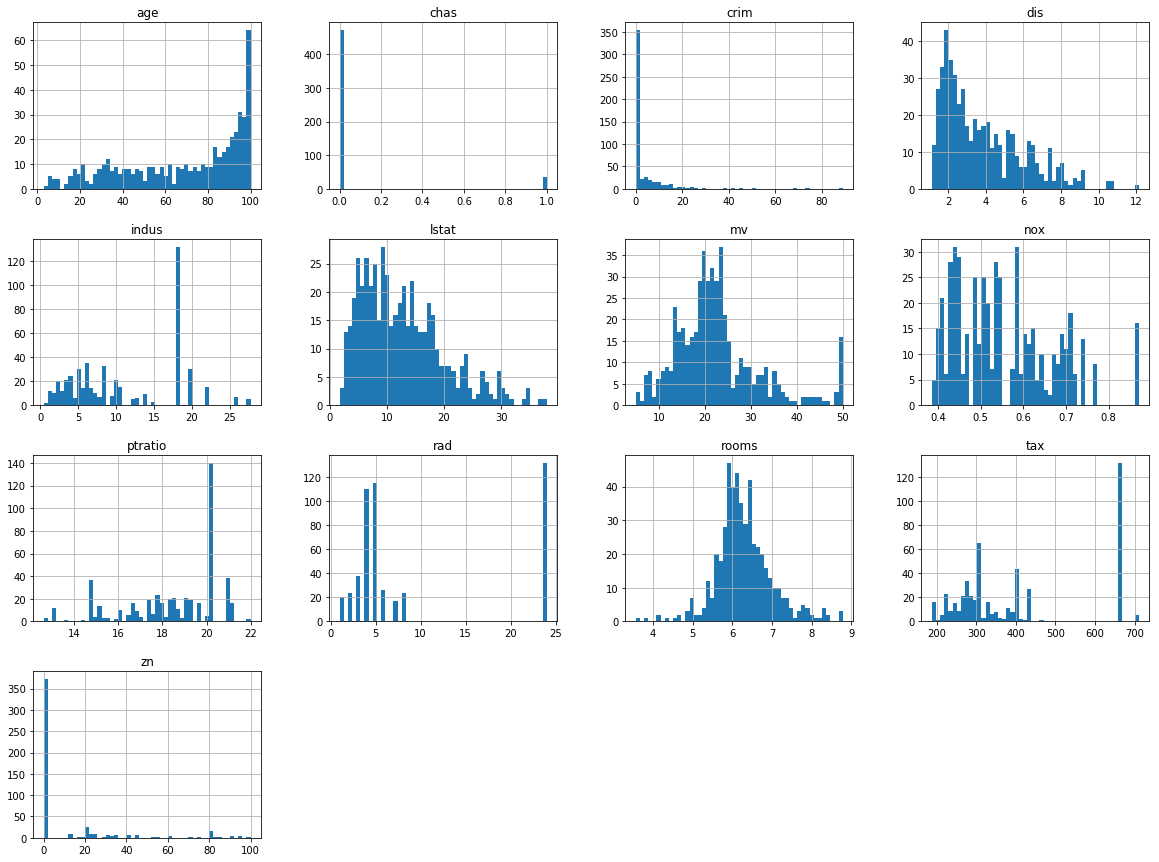

In [116]:
# view histograms of numeric variables
boston.hist(bins=50, figsize=(20,15))
plt.show()

Judging by the shape of some of these histograms it looks like you could potentially transform some of them for a
better overall shape. Age, dis, lstat, rad, tax and zn all could be transformed for a better distribution.

Also, it looks like age may have been capped at 100 and anything over that was then also just said to be 100 years 
old.

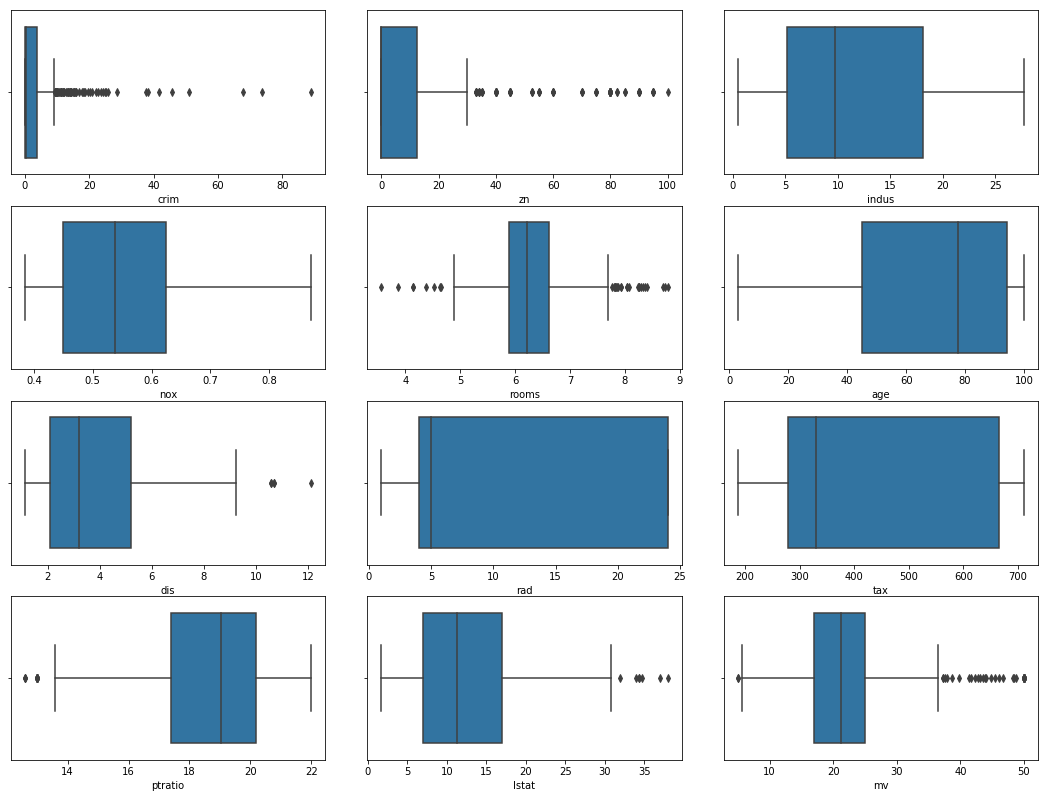

In [117]:
# View boxplots for potential outliers
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (15,11))
fig.tight_layout()
axes_ref1 = [0,0,0,1,1,1,2,2,2,3,3,3]
axes_ref2 = [0,1,2,0,1,2,0,1,2,0,1,2]
boston_sub = boston.drop('chas', 1)

for i in range(len(boston_sub.columns)):
  ax = axes[axes_ref1[i], axes_ref2[i]]
  sns.boxplot(boston_sub.iloc[:,i], ax = ax)

There are some potential outliers present in the following variables:

crim, zn, rooms, dis, ptratio, lstat and mv

# transform predictor variables

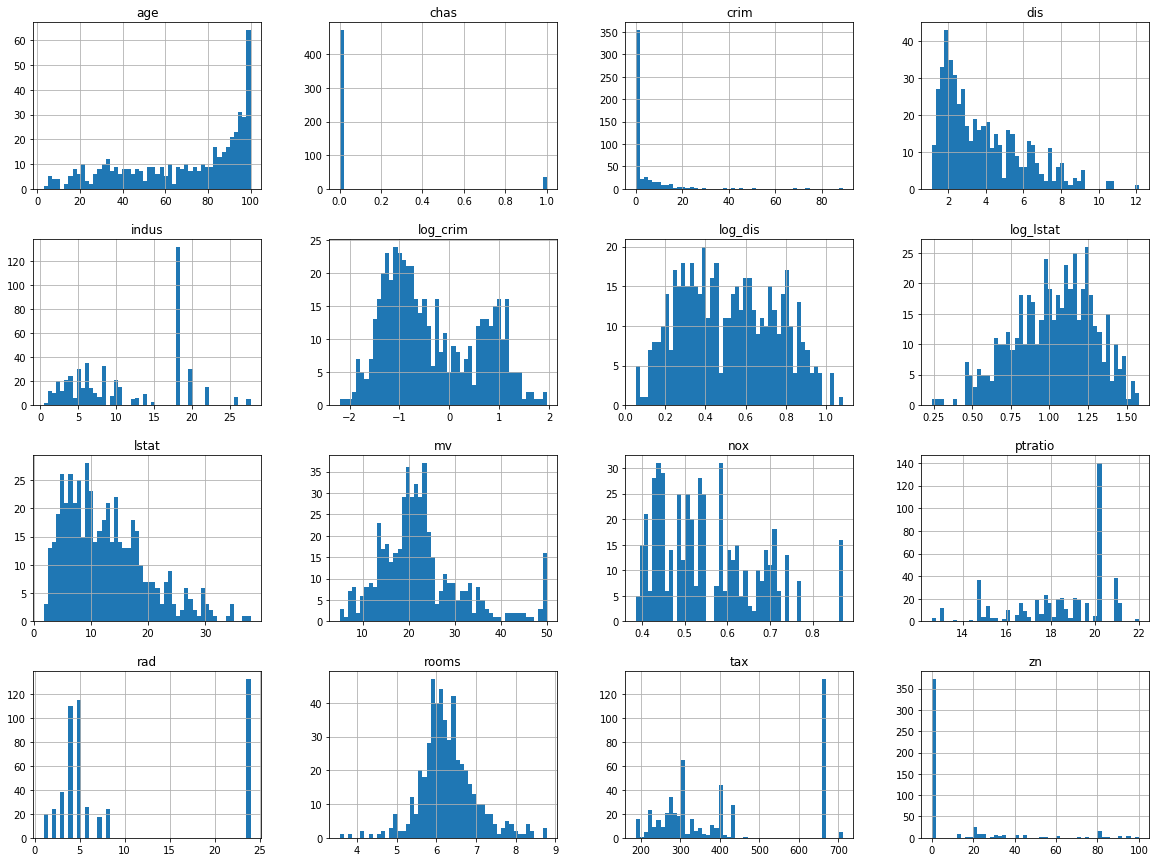

In [118]:
# look at log transform of some of the predictor variables
boston_log = boston
boston_log['log_crim'] = np.log10(boston['crim'])
boston_log['log_dis'] = np.log10(boston['dis'])
boston_log['log_lstat'] = np.log10(boston['lstat'])

# view histograms of numeric variables
boston_log.hist(bins=50, figsize=(20,15))
plt.show()

In [119]:
# drop original variables
boston_log = boston_log.drop('crim', 1)
boston_log = boston_log.drop('dis', 1)
boston_log = boston_log.drop('lstat', 1)
boston_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
zn           506 non-null float64
indus        506 non-null float64
chas         506 non-null int64
nox          506 non-null float64
rooms        506 non-null float64
age          506 non-null float64
rad          506 non-null int64
tax          506 non-null int64
ptratio      506 non-null float64
mv           506 non-null float64
log_crim     506 non-null float64
log_dis      506 non-null float64
log_lstat    506 non-null float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


# standardize original dataset

In [120]:
# Get columns in proper order for modeling
prelim_model_data = np.array([boston.mv,\
    boston.crim,\
    boston.zn,\
    boston.indus,\
    boston.chas,\
    boston.nox,\
    boston.rooms,\
    boston.age,\
    boston.dis,\
    boston.rad,\
    boston.tax,\
    boston.ptratio,\
    boston.lstat]).T

In [121]:
# standardscaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
model_data_standard = scaler.fit_transform(prelim_model_data)
model_data_standard_df = pd.DataFrame(model_data_standard, columns=['mv', 'crim', 'zn', 'indus', 'chas', 'nox', 
                                                                    'rooms', 'age', 'dis','rad', 'tax', 'ptratio', 
                                                                    'lstat'])

In [122]:
model_data_standard_df.head()

,mv,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat
0,0.160376,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,-1.075562
1,-0.101258,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,-0.492439
2,1.326830,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,-1.208727
3,1.185112,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,-1.361517
4,1.490352,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,-1.026501


In [123]:
# minmaxscaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
model_data_minmax = scaler.fit_transform(prelim_model_data)
model_data_minmax_df = pd.DataFrame(model_data_minmax, columns=['mv', 'crim', 'zn', 'indus', 'chas', 'nox', 
                                                                    'rooms', 'age', 'dis','rad', 'tax', 'ptratio', 
                                                                    'lstat'])

In [124]:
model_data_minmax_df.head()

,mv,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat
0,0.422222,0.000000,0.18,0.067815,0.0,0.314815,0.577505,0.641607,0.269203,0.000000,0.208015,0.287234,0.089680
1,0.368889,0.000236,0.00,0.242302,0.0,0.172840,0.547998,0.782698,0.348962,0.043478,0.104962,0.553191,0.204470
2,0.660000,0.000236,0.00,0.242302,0.0,0.172840,0.694386,0.599382,0.348962,0.043478,0.104962,0.553191,0.063466
3,0.631111,0.000293,0.00,0.063050,0.0,0.150206,0.658555,0.441813,0.448545,0.086957,0.066794,0.648936,0.033389
4,0.693333,0.000705,0.00,0.063050,0.0,0.150206,0.687105,0.528321,0.448545,0.086957,0.066794,0.648936,0.099338


# model building

In [125]:
# define learning cuvres function
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=23)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)  
    plt.xlim([0, 150])

## linear regression

Training set score: 0.820
Test set score: 0.775
RMSE: 4.104


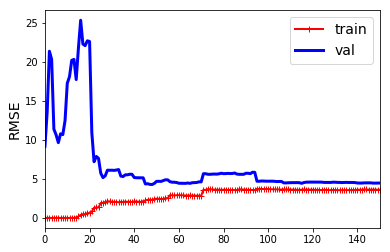

In [126]:
# basic linear regression model on normal data
from sklearn.linear_model import LinearRegression
X = boston.drop(columns=['mv'])
y = pd.DataFrame(boston['mv'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)
lr_normal = LinearRegression().fit(X_train, y_train)
scores = -cross_val_score(lr_normal, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

print("Training set score: {:.3f}".format(lr_normal.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lr_normal.score(X_test, y_test)))
print("RMSE: {:.3f}".format(np.mean(np.sqrt(scores))))
    
plot_learning_curves(lr_normal, X, y)
plt.show()

Training set score: 0.795
Test set score: 0.771
RMSE: 4.287


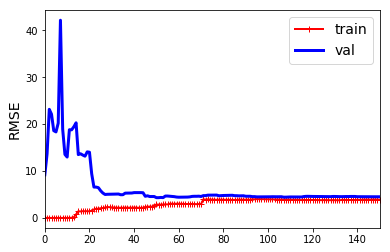

In [127]:
# basic linear regression model on transformed data
from sklearn.linear_model import LinearRegression
X = boston_log.drop(columns=['mv'])
y = pd.DataFrame(boston_log['mv'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)
lr_log = LinearRegression().fit(X_train, y_train)
scores = -cross_val_score(lr_log, X_train, y_train, cv=10, scoring='neg_mean_squared_error')


print("Training set score: {:.3f}".format(lr_log.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lr_log.score(X_test, y_test)))
print("RMSE: {:.3f}".format(np.mean(np.sqrt(scores))))
    
plot_learning_curves(lr_log, X, y)
plt.show()

Training set score: 0.744
Test set score: 0.716
RMSE: 0.104


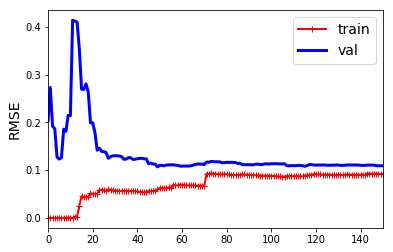

In [128]:
# basic linear regression model on minmax scaled data
from sklearn.linear_model import LinearRegression
X = model_data_minmax_df.drop(columns=['mv'])
y = pd.DataFrame(model_data_minmax_df['mv'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)
lr_minmax = LinearRegression().fit(X_train, y_train)
scores = -cross_val_score(lr_minmax, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

print("Training set score: {:.3f}".format(lr_minmax.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lr_minmax.score(X_test, y_test)))
print("RMSE: {:.3f}".format(np.mean(np.sqrt(scores))))
    
plot_learning_curves(lr_minmax, X, y)
plt.show()

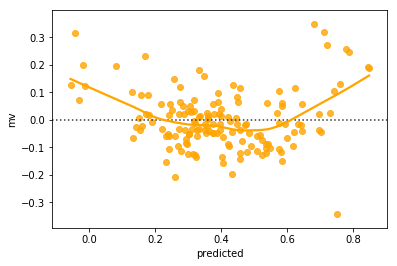

In [129]:
# look at fit/residula plots
y_test_chk = y_test
y_test_chk['predicted']=lr_minmax.predict(X_test)

# Plot the residuals after fitting a linear model
sns.residplot(y_test_chk['predicted'], y_test_chk['mv'], lowess=True, color="orange")

There is definitely not constant variance here as we don't see good randomness

In [130]:
lr_yhat = lr_minmax.predict(X_train)
lr_resid = y_train - lr_yhat

#fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,4))
#fig.suptitle('Residual Plots')

#ax1 = axes[0]
#sns.residplot(lasso0001_yhat, lasso_resid, lowess=True, color=current_palette[0], ax=ax1)
#ax1.set_title('Residuals vs Fitted Values')

Training set score: 0.744
Test set score: 0.716
RMSE: 0.512


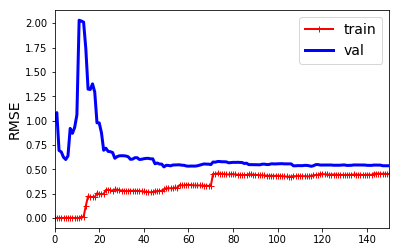

In [131]:
# basic linear regression model on standard scaled data
from sklearn.linear_model import LinearRegression
X = model_data_standard_df.drop(columns=['mv'])
y = pd.DataFrame(model_data_standard_df['mv'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)
lr_standard = LinearRegression().fit(X_train, y_train)
scores = -cross_val_score(lr_standard, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

print("Training set score: {:.3f}".format(lr_standard.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lr_standard.score(X_test, y_test)))
print("RMSE: {:.3f}".format(np.mean(np.sqrt(scores))))
    
plot_learning_curves(lr_standard, X, y)
plt.show()

None of these linear models did a really good job at prediction. The two scaled methods returned the same results, but a different magnitude of RMSE.

## lasso regression

In [132]:
# build a loop that goes through different levels of alpha using cv as score - it will then tell me which alpha had
# the best value for RMSE

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]

val_errors = []
for alpha in alphas:
    lasso_minmax = Lasso(alpha=alpha, fit_intercept=True, random_state=23)
    errors = np.sum(-cross_val_score(lasso_minmax, 
                                     X_train, 
                                     y_train, 
                                     scoring='neg_mean_squared_error', 
                                     cv=10,
                                     n_jobs=-1))
    val_errors.append(np.sqrt(errors))

In [133]:
print('best alpha: {}'.format(alphas[np.argmin(val_errors)]))

best alpha: 0.001


The best alpha level was 0.0001 - which means we fit a model very similar to the linear regression model. Fitting as complex of a model as possible

Training set score: 0.744
Test set score: 0.715
RMSE: 0.104


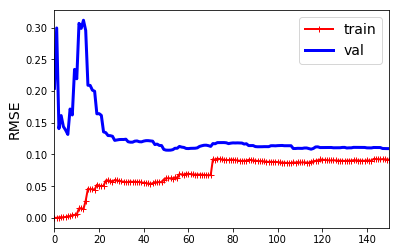

In [134]:
# use minmax scaled data
X = model_data_minmax_df.drop(columns=['mv'])
y = pd.DataFrame(model_data_minmax_df['mv'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)
lasso_minmax = Lasso(alpha = 0.0001).fit(X_train, y_train)
scores = -cross_val_score(lasso_minmax, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

print("Training set score: {:.3f}".format(lasso_minmax.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lasso_minmax.score(X_test, y_test)))
print("RMSE: {:.3f}".format(np.mean(np.sqrt(scores))))
    
plot_learning_curves(lasso_minmax, X, y)
plt.show()

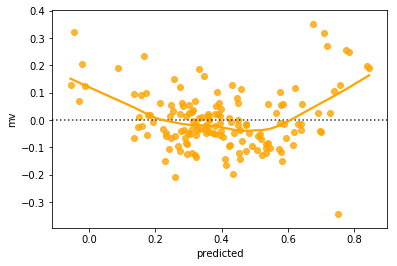

In [135]:
# look at fit/residula plots
y_test_chk = y_test
y_test_chk['predicted']=lasso_minmax.predict(X_test)

# Plot the residuals after fitting a linear model
sns.residplot(y_test_chk['predicted'], y_test_chk['mv'], lowess=True, color="orange")

In [136]:
print("Number of features used:", np.sum(lasso_minmax.coef_ != 0))

Number of features used: 12


Used all 12 features!

Training set score: 0.795
Test set score: 0.771
RMSE: 4.287


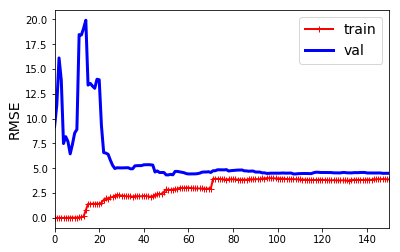

In [137]:
# use log scaled parameters
X = boston_log.drop(columns=['mv'])
y = pd.DataFrame(boston_log['mv'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)
lasso_log = Lasso(alpha = 0.001).fit(X_train, y_train)
scores = -cross_val_score(lasso_log, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

print("Training set score: {:.3f}".format(lasso_log.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lasso_log.score(X_test, y_test)))
print("RMSE: {:.3f}".format(np.mean(np.sqrt(scores))))
    
plot_learning_curves(lasso_log, X, y)
plt.show()

In [138]:
print("Number of features used:", np.sum(lasso_log.coef_ != 0))

Number of features used: 12


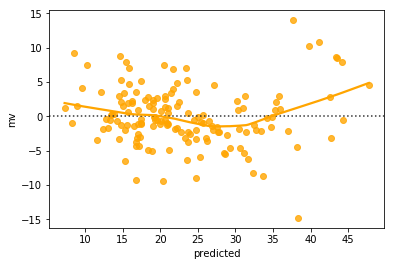

In [139]:
# look at fit/residula plots
y_test_chk = y_test
y_test_chk['predicted']=lasso_log.predict(X_test)

# Plot the residuals after fitting a linear model
sns.residplot(y_test_chk['predicted'], y_test_chk['mv'], lowess=True, color="orange")

Had overall the best results so far.

## elastic net

In [140]:
# build a loop that goes through different levels of alpha using cv as score - it will then tell me which alpha had
# the best value for RMSE

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]

val_errors = []
for alpha in alphas:
    elastic_minmax = ElasticNet(alpha=alpha, fit_intercept=True, random_state=23)
    errors = np.sum(-cross_val_score(elastic_minmax, 
                                     X_train, 
                                     y_train, 
                                     scoring='neg_mean_squared_error', 
                                     cv=10,
                                     n_jobs=-1))
    val_errors.append(np.sqrt(errors))

In [141]:
print('best alpha: {}'.format(alphas[np.argmin(val_errors)]))

best alpha: 0.0001


Training set score: 0.744
Test set score: 0.716
RMSE: 0.104


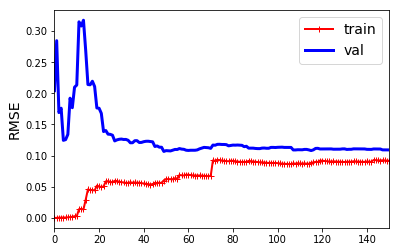

In [142]:
# use minmax scaled data
X = model_data_minmax_df.drop(columns=['mv'])
y = pd.DataFrame(model_data_minmax_df['mv'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)
elastic_minmax = ElasticNet(alpha = 0.0001, l1_ratio = 0.2).fit(X_train, y_train)
scores = -cross_val_score(elastic_minmax, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

print("Training set score: {:.3f}".format(elastic_minmax.score(X_train, y_train)))
print("Test set score: {:.3f}".format(elastic_minmax.score(X_test, y_test)))
print("RMSE: {:.3f}".format(np.mean(np.sqrt(scores))))
    
plot_learning_curves(elastic_minmax, X, y)
plt.show()

In [143]:
print("Number of features used:", np.sum(elastic_minmax.coef_ != 0))

Number of features used: 12


This shows the same type of results as the linear regression and lasso on the minmax scaled data.

## random forests

#### base rf model

In [199]:
# make copy of original boston dataset
boston_orig = boston

In [200]:
# train random forest regressor on original dataset
from sklearn.ensemble import RandomForestRegressor

X = boston_orig.drop(columns=['mv'])
y = pd.DataFrame(boston_orig['mv'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)
rf_normal = RandomForestRegressor(n_jobs=-1, bootstrap=True)
rf_normal.fit(X_train, y_train)
scores_rf_norm = -cross_val_score(rf_normal, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

print("Training set score: {:.3f}".format(rf_normal.score(X_train, y_train)))
print("Test set score: {:.3f}".format(rf_normal.score(X_test, y_test)))
print("RMSE: {:.3f}".format(np.mean(np.sqrt(scores_rf_norm))))

Training set score: 0.979
Test set score: 0.819
RMSE: 2.991


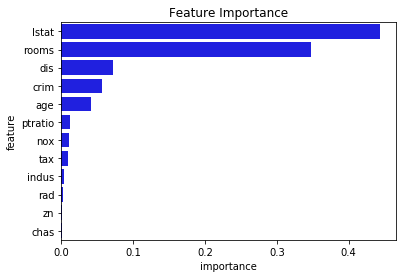

In [252]:
# feature importance
feat = pd.DataFrame({'importance':rf_normal.feature_importances_})
feat['feature'] = X_train.columns
feat.sort_values(by='importance', ascending=False, inplace=True)
sns.barplot(data = feat, y = "feature", x = "importance", color = "b")
plt.title("Feature Importance")
plt.show()

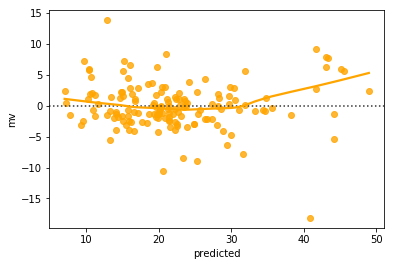

In [257]:
y_test_chk = y_test
y_test_chk['predicted']=rf_normal.predict(X_test)

# Plot the residuals after fitting a linear model
sns.residplot(y_test_chk['predicted'], y_test_chk['mv'], lowess=True, color="orange")

#### implement GridSearchCV

In [270]:
rf_param_grid = { 
    'bootstrap': [True],
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'log2'],
    'max_depth' : [10,20,30,40],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4]
}

In [195]:
# run GridSearchSV
rf = RandomForestRegressor(random_state=23)
CV_rf = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=10)
CV_rf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=23, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'bootstrap': [True], 'n_estimators': [100, 200, 300], 'max_features': ['auto', 'log2'], 'max_depth': [10, 20, 30, 40, 50], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [196]:
# find best params
CV_rf.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

#### run rf with optimized params

In [261]:
# run base rf model with best params
X = boston_orig.drop(columns=['mv'])
y = pd.DataFrame(boston_orig['mv'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)
rfGrid = RandomForestRegressor(bootstrap=True, max_depth=30, max_features='auto', min_samples_leaf=1,
                                  min_samples_split=2, n_estimators=200, n_jobs=-1)
rfGrid.fit(X_train, y_train)
scores_rfGrid = -cross_val_score(rfGrid, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

print("Training set score: {:.3f}".format(rfGrid.score(X_train, y_train)))
print("Test set score: {:.3f}".format(rfGrid.score(X_test, y_test)))
print("RMSE: {:.3f}".format(np.mean(np.sqrt(scores_rfGrid))))

Training set score: 0.986
Test set score: 0.831
RMSE: 2.867


The grid search improved the random forest model, slightly, but nonetheless improved.

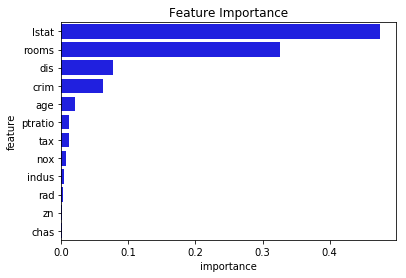

In [251]:
# feature importance
feat = pd.DataFrame({'importance':rfGrid.feature_importances_})
feat['feature'] = X_train.columns
feat.sort_values(by='importance', ascending=False, inplace=True)
sns.barplot(data = feat, y = "feature", x = "importance", color = "b")
plt.title("Feature Importance")
plt.show()

Again, the percentage of lower-socio economic status population and average number of rooms in the house apear to be the most important. Distance to employment centers and crim rate also follow.

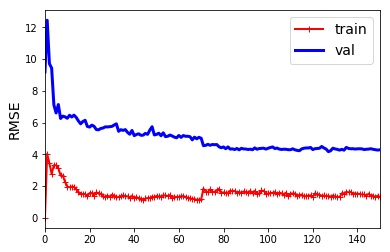

In [262]:
# plot learning curves
plot_learning_curves(rfGrid, X, y)
plt.show()

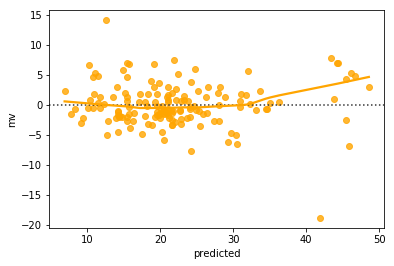

In [255]:
y_test_chk = y_test
y_test_chk['predicted']=rfGrid.predict(X_test)

# Plot the residuals after fitting a linear model
sns.residplot(y_test_chk['predicted'], y_test_chk['mv'], lowess=True, color="orange")

Residual plot looks much improved over lasso and OLS regression

#### gradient boosted model

In [268]:
from sklearn.ensemble import GradientBoostingRegressor

X = boston_orig.drop(columns=['mv'])
y = pd.DataFrame(boston_orig['mv'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

gb_normal = GradientBoostingRegressor(random_state=23)
gb_normal.fit(X_train, y_train)
scores_gb_norm = -cross_val_score(gb_normal, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

print("Training set score: {:.3f}".format(gb_normal.score(X_train, y_train)))
print("Test set score: {:.3f}".format(gb_normal.score(X_test, y_test)))
print("RMSE: {:.3f}".format(np.mean(np.sqrt(scores_gb_norm))))

Training set score: 0.984
Test set score: 0.842
RMSE: 2.737


#### run grid search for gradient boosted model

In [389]:
gb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.075, 0.08, 0.1],
    'max_features': ['log2'],
    'max_depth' : [1,3,5,7],
    'min_samples_split': [2,5,10,15],
    'min_samples_leaf': [1,2,4,6],
    'n_estimators': [50,100,200,500]
}

In [390]:
# run GridSearchSV
gb = GradientBoostingRegressor(random_state=23)
CV_gb = GridSearchCV(estimator=gb, param_grid=gb_param_grid, cv=10, scoring='neg_mean_squared_error')
CV_gb.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=23, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.01, 0.05, 0.075, 0.08, 0.1], 'max_features': ['log2'], 'max_depth': [1, 3, 5, 7], 'min_samples_split': [2, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6], 'n_estimators': [50, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [391]:
# find best params
CV_gb.best_params_

{'learning_rate': 0.075,
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

#### run gb with optimized params

In [387]:
X = boston_orig.drop(columns=['mv'])
y = pd.DataFrame(boston_orig['mv'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

gb_grid = GradientBoostingRegressor(learning_rate=0.075, max_features='log2', max_depth=5, min_samples_leaf=2,
                                    min_samples_split=2, n_estimators=500, random_state=23)
gb_grid.fit(X_train, y_train)
scores_gb_grid = -cross_val_score(gb_grid, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

print("Training set score: {:.3f}".format(gb_grid.score(X_train, y_train)))
print("Test set score: {:.3f}".format(gb_grid.score(X_test, y_test)))
print("RMSE: {:.3f}".format(np.mean(np.sqrt(scores_gb_grid))))

Training set score: 1.000
Test set score: 0.875
RMSE: 2.632


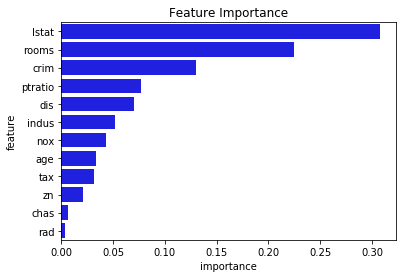

In [388]:
# feature importance
feat = pd.DataFrame({'importance':gb_grid.feature_importances_})
feat['feature'] = X_train.columns
feat.sort_values(by='importance', ascending=False, inplace=True)
sns.barplot(data = feat, y = "feature", x = "importance", color = "b")
plt.title("Feature Importance")
plt.show()

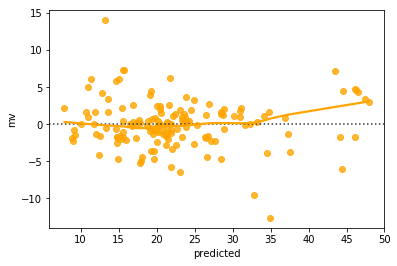

In [392]:
# residual check
y_test_chk = y_test
y_test_chk['predicted']=gb_grid.predict(X_test)

# Plot the residuals after fitting a linear model
sns.residplot(y_test_chk['predicted'], y_test_chk['mv'], lowess=True, color="orange")

Overall, I saw the best performance with the gradient boosted model. However, it does seem to be overfitting and would need to further optimize the parameters being used to prevent this.

#### try XGBoost as an aside

In [404]:
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.075, 0.08, 0.1],
    'max_features': ['log2'],
    'max_depth' : [1,3,5,7]
}

In [ ]:
# run GridSearchSV
xgb = GradientBoostingRegressor(objective ='reg:linear', random_state=23)
CV_xgb = GridSearchCV(estimator=xgb, param_grid=gb_param_grid, cv=10, scoring='neg_mean_squared_error')
CV_gb.fit(X_train, y_train)

In [ ]:
# find best params
CV_xgb.best_params_

In [416]:
from xgboost import XGBRegressor
X = boston_orig.drop(columns=['mv'])
y = pd.DataFrame(boston_orig['mv'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)


xgb_normal = XGBRegressor(objective ='reg:linear', learning_rate = 0.075, max_depth = 5, max_features='log2',
                              n_estimators = 500, random_state=23)
xgb_normal.fit(X_train, y_train)
scores_xgb_grid = -cross_val_score(xgb_normal, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

print("Training set score: {:.3f}".format(xgb_normal.score(X_train, y_train)))
print("Test set score: {:.3f}".format(xgb_normal.score(X_test, y_test)))
print("RMSE: {:.3f}".format(np.mean(np.sqrt(scores_xgb_grid))))

Training set score: 1.000
Test set score: 0.817
RMSE: 2.742


Didn't see substantial improvement